# Notebook 2-5: HMM Task Analysis

In this notebook, we will cover:
1. **Epoch state time courses and create constrasts**: We will epoch state time courses with task events and create contrasts.
2. **Evoked network responses**: We will perform statistical tests and visualise evoked network responses for different contrasts.

# 1. Epoch state time courses
We will epoch the state time courses with task events. Note that the state time courses are inferred from the HMM, which has no knowledge of the task structure in the data. Again, we will start with loading the state probabilities:

In [1]:
import pickle
from osl_dynamics.inference import modes

alp = pickle.load(open("results/inf_params/alp.pkl", "rb"))
stc = modes.argmax_time_courses(alp)

We will also need to load the original `.fif` files to get the task event onsets.

In [2]:
from glob import glob

parc_files = sorted(glob("wakeman-henson/*/*_sflip_lcmv-parc-raw.fif"))

Sanity check for same number of sessions in state time courses and original data:

In [3]:
print(len(stc), len(parc_files))

5 5


Now we extract the task events and epoch the state time courses. Please take some time to go through the code and make sure you understand what each step does. In short, we convert into `mne.io.Raw` objects and use the `mne.Epochs` API to extract the epochs.

In [4]:
import mne
import numpy as np
# Event IDs
new_event_ids = {"famous": 1, "unfamiliar": 2, "scrambled": 3}
old_event_ids = {
    "famous": [5, 6, 7],
    "unfamiliar": [13, 14, 15],
    "scrambled": [17, 18, 19],
}

visual_all = []
faces_vs_scrambled = []

# Loop through sessions
for s, p in zip(stc, parc_files):

    # Create an MNE raw object
    raw = modes.convert_to_mne_raw(s, p, n_embeddings=15)

    # Find events
    events = mne.find_events(raw, min_duration=0.005, verbose=False)
    for old_event_codes, new_event_codes in zip(old_event_ids.values(), new_event_ids.values()):
        events = mne.merge_events(events, old_event_codes, new_event_codes)

    # Epoch
    epochs = mne.Epochs(raw, events, new_event_ids, tmin=-0.1, tmax=1.0)
    print(epochs)

    # First-level analysis
    # Get averaged state activation for each stimulus
    famous = epochs["famous"].get_data(picks="misc").mean(axis=0)
    unfamiliar = epochs["unfamiliar"].get_data(picks="misc").mean(axis=0)
    scrambled = epochs["scrambled"].get_data(picks="misc").mean(axis=0)

    # Total response for each state to all stimuli (famous faces, unfamiliar faces, scrambled faces)
    visual_all.append((famous + unfamiliar + scrambled) / 3)

    # Difference in state response for faces vs scrambled
    faces_vs_scrambled.append(famous + unfamiliar - 2 * scrambled)

visual_all = np.array(visual_all)
faces_vs_scrambled = np.array(faces_vs_scrambled)

# Get time axis and correct for the trigger delay
t = np.copy(epochs.times)
t -= 34e-3

Not setting metadata
148 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs | 148 events (good & bad), -0.1 – 1 s (baseline -0.1 – 0 s), ~12 KiB, data not loaded,
 'famous': 50
 'unfamiliar': 49
 'scrambled': 49>
Using data from preloaded Raw for 50 events and 276 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 49 events and 276 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 49 events and 276 original time points ...
1 bad epochs dropped
Not setting metadata
146 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs | 146 events (good & bad), -0.1 – 1 s (baseline -0.1 – 0 s), ~12 KiB, data not loaded,
 'famous': 49
 'unfamiliar': 47
 'scrambled': 50>
Using data from preloaded Raw for 49 events and 276 original time points ...
2 bad epochs drop

Next we will do a baseline correction to remove ongoing neural activity before the task onset.

In [5]:
visual_all -= np.mean(visual_all[..., t < 0], axis=-1, keepdims=True)
faces_vs_scrambled -= np.mean(faces_vs_scrambled[..., t < 0], axis=-1, keepdims=True)

Now we can use the permutation test on the maximum statistic to test for periods of significant evoked network responses.

In [6]:
from osl_dynamics.analysis import statistics

visual_all_pvalues = statistics.evoked_response_max_stat_perm(visual_all, n_perm=1000)
faces_vs_scrambled_pvalues = statistics.evoked_response_max_stat_perm(faces_vs_scrambled, n_perm=1000)

2025-05-16 16:54:05 INFO osl-dynamics [permutation.py:93:fit]: Running on contrast Mean permutations with 1 jobs.


Running permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-05-16 16:54:05 INFO osl-dynamics [permutation.py:93:fit]: Running on contrast Mean permutations with 1 jobs.


Running permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

Find the group-level response for visualisation.

In [7]:
visual_all_mean = np.mean(visual_all, axis=0)
faces_vs_scrambled_mean = np.mean(faces_vs_scrambled, axis=0)

2. **Evoked network responses**
In this section we will visualise the analysis we just performed.

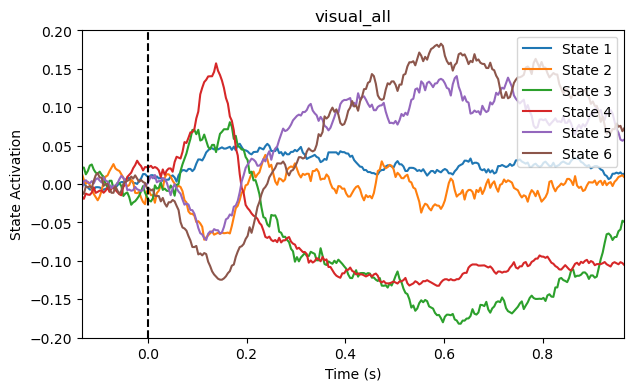

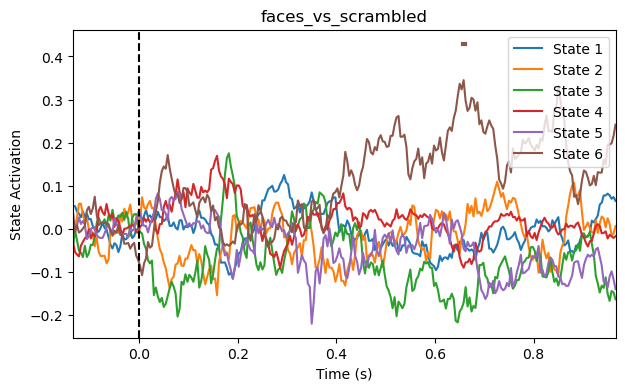

In [8]:
from osl_dynamics.utils import plotting

fig, ax = plotting.plot_evoked_response(
    t,
    visual_all_mean.T,
    visual_all_pvalues.T,
    significance_level=0.1,  # normally would use 0.05
    labels=[f"State {i}" for i in range(1, 7)],
    x_label="Time (s)",
    y_label="State Activation",
    title="visual_all",
)
fig.savefig("plots/network_response_0.png")

fig, ax = plotting.plot_evoked_response(
    t,
    faces_vs_scrambled_mean.T,
    faces_vs_scrambled_pvalues.T,
    significance_level=0.1,  # normally would use 0.05
    labels=[f"State {i}" for i in range(1, 7)],
    x_label="Time (s)",
    y_label="State Activation",
    title="faces_vs_scrambled",
)
fig.savefig("plots/network_response_1.png")

Exercise:
- When you have lots of sessions, how do you speed up the statistical tests?
- Can you calculate, test, and visualise the group-level response for famous vs non-famous faces?